<a href="https://colab.research.google.com/github/ashikshafi08/AICrowd_Competition_Files/blob/main/Fastai/Rover_Rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Mar 30 05:50:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --upgrade fastai  
!pip install aicrowd-cli==0.1
API_KEY =  
!aicrowd login --api-key $API_KEY

     |████████████████████████████████| 194kB 17.7MB/s 
     |████████████████████████████████| 12.8MB 229kB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 204kB 22.9MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 163kB 52.7MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 71kB 1

In [ ]:
!aicrowd dataset download --challenge mars-rotation
!rm -rf data
!mkdir data

!unzip -q train.zip  -d data/train
!unzip -q val.zip -d data/val
!unzip -q test.zip  -d data/test

!mv train.csv data/train.csv
!mv val.csv data/val.csv
!mv sample_submission.csv data/sample_submission.csv

sample_submission.csv: 100% 95.9k/95.9k [00:00<00:00, 678kB/s]
test.zip: 100% 76.5M/76.5M [00:02<00:00, 33.9MB/s]
train.csv: 100% 377k/377k [00:00<00:00, 1.32MB/s]
train.zip: 100% 306M/306M [00:07<00:00, 39.7MB/s]
val.csv: 100% 33.7k/33.7k [00:00<00:00, 519kB/s]
val.zip: 100% 30.6M/30.6M [00:01<00:00, 26.5MB/s]


In [ ]:
from fastai import * 
from fastai.vision.all import * 
import fastai 
print(fastai.__version__)
import pandas as pd 
import numpy as np

2.2.7


In [ ]:
# Getting the path of the data 
train_data = Path('data/train/')
test_data = Path('data/test/')
val_data = Path('data/val')

# Loading in the dataframe 
train_df = pd.read_csv('data/train.csv')

In [ ]:
# How does the train dataframe looks like ? 
train_df.head()

,ImageID,label
0,0,141
1,1,53
2,2,45
3,3,48
4,4,14


In [ ]:
# How many images are in train set? 
train_df.shape

(40000, 2)

In [ ]:
# How many labels / classes? 
train_df['label'].unique()

array([141,  53,  45,  48,  14, 360, 302,  82,  80, 177, 236, 194, 322,
       296, 339,  41, 195, 187, 344, 332, 274, 353,  29, 162, 291, 336,
       330, 127, 300, 186, 261,  57, 349, 196, 129,   6, 275, 175, 233,
       135, 260, 153, 102, 277,   1,  58, 158, 249, 273, 244, 271, 109,
       354, 265,  33, 118, 324,  17, 122, 293, 243,  50, 211, 345,  32,
        56, 230, 237, 227,  51,   8, 110,  85, 136, 147, 285,  98, 297,
       161, 258,  30,  96, 121, 292, 318, 290, 105, 154,  38, 289, 179,
       190, 279, 335, 284,  69, 108, 325,  23, 327,   5,  66,  21, 128,
       287,  91, 171, 343, 137, 114, 180, 117, 205, 143, 348,  15,  92,
        20,  60, 131, 267, 341, 340, 168, 316,  87, 234, 100,   3,  55,
       357, 259, 229,  40, 172,  71,  79, 209, 295, 181, 215, 309, 140,
       173, 319, 304,  94, 216,  10, 334,  59, 359, 311, 160, 193,  39,
       125, 351, 220, 251, 326, 276, 238, 133, 272, 282, 139,  99, 248,
       269, 155, 150, 252, 146,  95, 245,  28, 156, 286, 317, 23

In [ ]:
def append_ext(fn):
    return f'{fn}.jpg'

# Now applying them 
train_df['ImageID'] = train_df['ImageID'].apply(append_ext)

In [ ]:
train_df['label'].min(),train_df['label'].max()

(1, 360)

In [ ]:
# Transforms 

item_tfms=RandomResizedCrop(460)
batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
#item_tfms=Resize(460, method='squish')
#batch_tfms=[*aug_transforms(size=224, max_warp=0)]

In [ ]:
# Creating a DataBlock 
rover_rot_block = DataBlock(blocks = (ImageBlock , RegressionBlock()) , 
                            get_x = ColReader(0 , pref =f'{train_data}/') , 
                            get_y = ColReader(1) , 
                            splitter = RandomSplitter() , 
                            item_tfms = item_tfms , 
                            batch_tfms = batch_tfms)

# Getting the summary 
rover_rot_block.summary(train_df)

Setting-up type transforms pipelines
0          0.jpg    141
1          1.jpg     53
2          2.jpg     45
3          3.jpg     48
4          4.jpg     14
...          ...    ...
39995  39995.jpg    268
39996  39996.jpg    193
39997  39997.jpg    195
39998  39998.jpg    199
39999  39999.jpg     42

[40000 rows x 2 columns]
Found 40000 items
2 datasets of sizes 32000,8000
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': 'data/train/', 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': None} -> RegressionSetup -- {'c': None}

Building one sample
  Pipeline: ColReader -- {'cols': 0, 'pref': 'data/train/', 'suff': '', 'label_delim': None} -> PILBase.create
    starting from
      ImageID    39066.jpg
label            194
Name: 39066, dtype: object
    applying ColReader -- {'cols': 0, 'pref': 'data/train/', 'suff': '', 'label_delim': None} gives
      data/train/39066.jpg
    applying PILBase.create

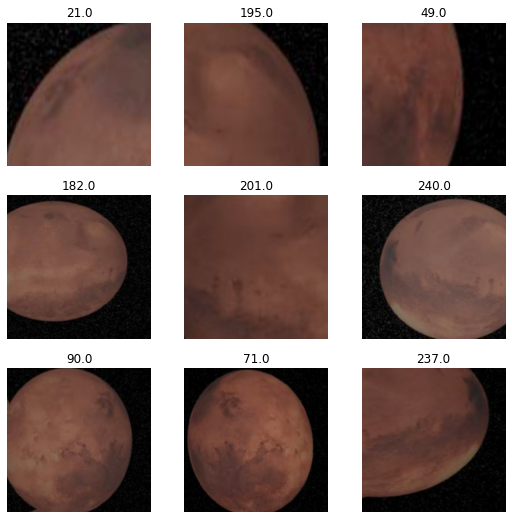

In [ ]:
# Creating a dataloaders 
train_dls = rover_rot_block.dataloaders(train_df , batch_size= 32)

# Viewing the image 
train_dls.show_batch()

In [ ]:
# Getting our evaluation metrics 
from fastai.metrics import mse

In [ ]:
# Building a learner 
learn = cnn_learner(train_dls , resnet50 , loss_func= MSELossFlat() , metrics = mse , y_range = (0.5 , 360.0) )

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
# For 3 epochs
learn.fit_one_cycle(3 , 3e-4)

epoch,train_loss,valid_loss,mse,time
0,7164.386230,2536.653320,2536.653320,05:54
1,3046.157715,741.264038,741.264038,05:55
2,2785.826172,595.069641,595.069641,05:55


In [ ]:
# Unfreezing all the networks 
learn.unfreeze()

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=9.12010818865383e-07)

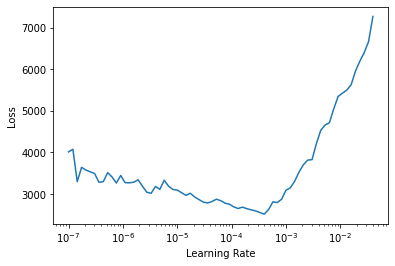

In [ ]:
# Findng the learning rate 
learn.lr_find()

In [ ]:
# Fine tuning the model 
learn.fit_one_cycle(10 , lr_max= slice(1e-5 , 1e-4))

epoch,train_loss,valid_loss,mse,time
0,1892.383301,479.084137,479.084137,07:24
1,1634.556763,382.665863,382.665863,07:25
2,1165.293701,402.719025,402.719025,07:24
3,715.723389,178.534271,178.534271,07:24
4,931.550476,130.188187,130.188187,07:23
5,735.251404,178.666702,178.666702,07:23
6,537.605652,261.572632,261.572632,07:23
7,588.332214,142.620285,142.620285,07:23
8,451.510345,113.771477,113.771477,07:23
9,376.791321,102.864037,102.864037,07:24


In [ ]:
# Test image file names 
test_fns = get_image_files(test_data)
test_fns

(#10000) [Path('data/test/1058.jpg'),Path('data/test/8855.jpg'),Path('data/test/2752.jpg'),Path('data/test/6572.jpg'),Path('data/test/6609.jpg'),Path('data/test/3380.jpg'),Path('data/test/4964.jpg'),Path('data/test/6592.jpg'),Path('data/test/1154.jpg'),Path('data/test/9742.jpg')...]

In [ ]:
# Load the test data 
test_dls = train_dls.test_dl(test_fns)

test_img_ids = [re.sub(r"\D", "", str(img_name)) for img_name in test_fns]
test_img_ids

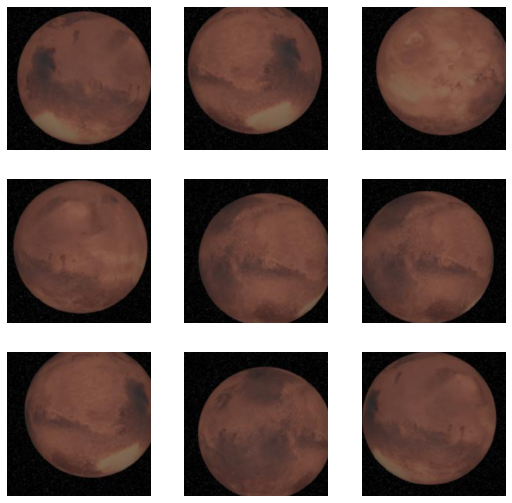

In [ ]:
# Looking at our test batch 
test_dls.show_batch()

In [ ]:
# Storing the results 
_,_,results = learn.get_preds(dl = test_dls, with_decoded = True)

results = [i[0] for i in results.numpy()]

In [ ]:
# Saving the predictions 
submission = pd.DataFrame({"ImageID":test_img_ids, "label":results})
submission

,ImageID,label
0,1058,259.182983
1,8855,316.519348
2,2752,118.087921
3,6572,208.539566
4,6609,358.859558
...,...,...
9995,8416,188.648956
9996,1207,185.117935
9997,2097,301.458496
9998,558,216.523865


In [ ]:
# Converting into csv 
submission.to_csv('submission.csv' , index = False)